# Practice Exercise: Scikit-Learn 4
### Cross-Validation and Hyper-parameter Tuning¶

### Objectives

As in the [SK4 Tutorial](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-4-cross-validation-and-hyperparameter-tuning/), the objective of this practice notebook is to illustrate how you can perform cross-validation and hyper-parameter tuning using `Scikit-Learn`. You will also perform paired t-tests to determine statistically significant performance results, as explained [here](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-5-advanced-topics-pipelines-statistical-model-comparison-and-model-deployment/#4). 

You will be using the cleaned "income data" dataset. In the previous practices, you cleaned and transformed the raw `income data` and renamed the `income` column as `target` (with high income being the positive class). Including `target`, the cleaned data consists of 42 columns and 45,222 rows. Each column is numeric and between 0 and 1.

In `GridSearchCV()`, try setting `n_jobs` to -2 for shorter run times with parallel processing. Here, -2 means use all core except 1. See [SK5 Tutorial](https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-5-advanced-topics-pipelines-statistical-model-comparison-and-model-deployment/) for more details.

### Instructions

- For ease of computation, you will first randomly sample 5,000 rows from this dataset. 
- You will then split this sample into 70% train and 30% test datasets. 
- You will use the first set for **training**: you will fine tune your models using this train data. 
- You will use the second set for **testing**: you will perform cross-validation in a paired fashion using the test data and then you will compare the performance of your tuned models using a paired t-test.
- You will use **stratified 5-fold cross-validation with no repetitions** during both training and testing.
- For scoring, you will use AUC, that is, "area under the ROC curve". 

### Some Bookkeeping

- Define a variable called `num_samples` and set it to 5000. You will use this variable when sampling a smaller subset of the full set of instances.
- Define a variable called `num_features` and set it to 10. Prior to fitting any models, you will perform feature selection by making use of this `num_features` variable.
- Define a variable called `scoring_metric` and set it to to `'roc_auc'`. You will set `scoring` option in all `cross_val_score()` functions to this `scoring_metric` variable.

You can achieve these by running the code chunk below:
```Python
import numpy as np
np.random.seed(999)
num_samples = 5000
scoring_metric = 'roc_auc'
num_features = 10
```

### Exercise 0: Modeling Preparation

- Read in the clean data `us_census_income_data_clean_encoded.csv` on GitHub [here](https://github.com/vaksakalli/datasets). 
- Randomly sample 5000 rows using a random seed of 999.
- Split the sampled data as 70% training set and the remaining 30% test set using a random seed of 999. 
- Remember to separate `target` during the splitting process. 

In [1]:
import numpy as np
np.random.seed(999)
num_samples = 5000
scoring_metric = 'roc_auc'
num_features = 10

In [2]:
import pandas as pd

# so that we can see all the columns
pd.set_option('display.max_columns', None) 

df = pd.read_csv('us_census_income_data_clean_encoded.csv')

print(df.shape)
df.head().round(3)

(45222, 42)


,age,education_num,race,gender,hours_per_week,native_country,capital,workclass_federal_gov,workclass_local_gov,workclass_private,workclass_self_emp_inc,workclass_self_emp_not_inc,workclass_state_gov,workclass_without_pay,marital_status_divorced,marital_status_married_af_spouse,marital_status_married_civ_spouse,marital_status_married_spouse_absent,marital_status_never_married,marital_status_separated,marital_status_widowed,occupation_adm_clerical,occupation_armed_forces,occupation_craft_repair,occupation_exec_managerial,occupation_farming_fishing,occupation_handlers_cleaners,occupation_machine_op_inspct,occupation_other_service,occupation_priv_house_serv,occupation_prof_specialty,occupation_protective_serv,occupation_sales,occupation_tech_support,occupation_transport_moving,relationship_husband,relationship_not_in_family,relationship_other_relative,relationship_own_child,relationship_unmarried,relationship_wife,target
0,0.301,0.800,1,1,0.398,1,0.063,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0.452,0.800,1,1,0.122,1,0.042,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.288,0.533,1,1,0.398,1,0.042,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.493,0.400,0,1,0.398,1,0.042,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0.151,0.800,0,0,0.398,0,0.042,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [3]:
df_sample = df.sample(n=num_samples, random_state=999).reset_index(drop=True)

df_sample.shape

(5000, 42)

In [4]:
from sklearn.model_selection import train_test_split
target = df_sample['target']
Data_df = df_sample.drop(columns = 'target')
Data_numpy = Data_df.values
D_train, D_test, t_train, t_test = train_test_split(Data_numpy, 
                                                    target.values, 
                                                    shuffle=True,
                                                    test_size=0.3, 
                                                    random_state=999)

### Exercise 1

Determine the most important 10 features as selected by Random Forest Importance (RFI) using the **training** data and visualize them.

In the rest of these exercises, you will use these selected features and not the whole set of descriptive features. You can achieve this as below:
```Python
D_Train_fs = D_train[:, fs_indices_rfi]
D_Test_fs  = D_test[:, fs_indices_rfi]
```

In [5]:
from sklearn.ensemble import RandomForestClassifier

num_features = 10
model_rfi = RandomForestClassifier(n_estimators=100, random_state=999)
model_rfi.fit(Data_numpy, target)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['age', 'capital', 'education_num', 'hours_per_week',
       'marital_status_married_civ_spouse', 'relationship_husband',
       'occupation_exec_managerial', 'marital_status_never_married',
       'occupation_prof_specialty', 'gender'], dtype=object)

In [6]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.21631283, 0.13899253, 0.13141843, 0.10456133, 0.08193192,
       0.0476534 , 0.02514301, 0.02180854, 0.01912856, 0.01692581])

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

def plot_imp(best_features, scores, method_name):   
    plt.barh(best_features, scores)
    plt.title(method_name + ' Feature Importances')
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.show()

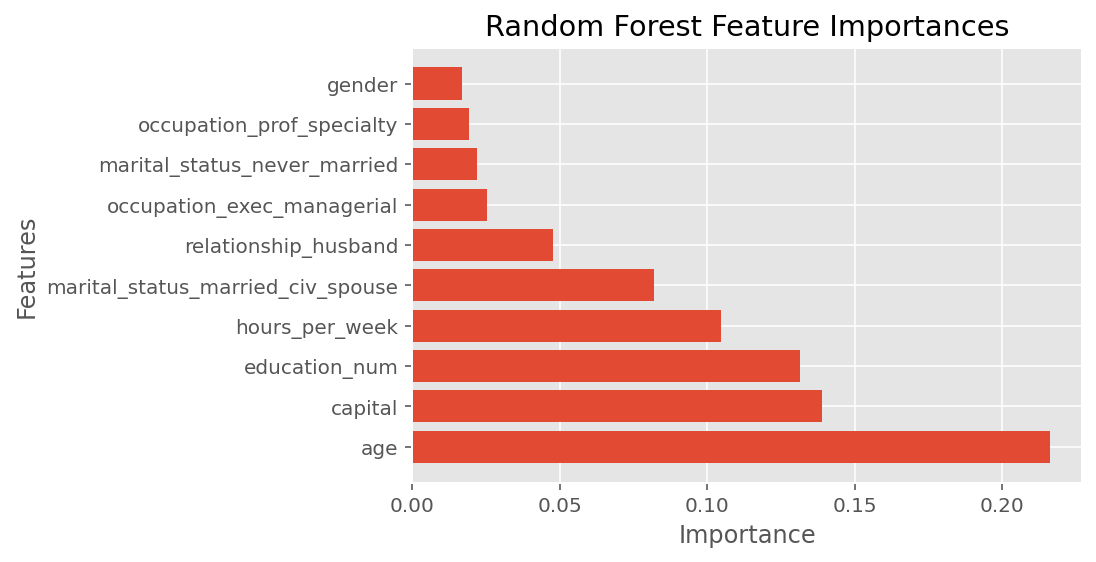

In [8]:
plot_imp(best_features_rfi, feature_importances_rfi, 'Random Forest')

In [9]:
# from this point forward, we will only work with the selected features
D_Train_fs = D_train[:, fs_indices_rfi]
D_Test_fs  = D_test[:, fs_indices_rfi]

### Exercise 2

Fit and fine-tune a KNN model using the **train** data. For fine-tuning, consider K values in {1, 5, 10, 15, 20} and p values in {1, 2}. Also visualize the tuning results.

In [10]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv_method_train = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)

In [11]:
import numpy as np
params_KNN = {'n_neighbors': [1, 5, 10, 15, 20, 25, 30], 'p': [1, 2]}

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

gs_KNN = GridSearchCV(estimator=KNeighborsClassifier(), 
                      param_grid=params_KNN, 
                      cv=cv_method_train,
                      verbose=1,
                      scoring=scoring_metric)

In [13]:
gs_KNN.fit(D_Train_fs, t_train);

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [14]:
gs_KNN.best_params_

{'n_neighbors': 30, 'p': 1}

In [15]:
gs_KNN.best_score_

0.8692219679655728

In [16]:
# To extract more cross-validation results, we can call gs.csv_results 
# - a dictionary consisting of run details for each fold.
gs_KNN.cv_results_['mean_test_score']

array([0.69541487, 0.70190213, 0.83482606, 0.83603535, 0.85964085,
       0.85958014, 0.86577897, 0.86489486, 0.86791486, 0.86548364,
       0.86856082, 0.86698149, 0.86922197, 0.86660173])

In [17]:
results_KNN = pd.DataFrame(gs_KNN.cv_results_['params'])

In [18]:
results_KNN['test_score'] = gs_KNN.cv_results_['mean_test_score']

In [19]:
results_KNN['metric'] = results_KNN['p'].replace([1,2], ["Manhattan", "Euclidean"])
results_KNN

,n_neighbors,p,test_score,metric
0,1,1,0.695415,Manhattan
1,1,2,0.701902,Euclidean
2,5,1,0.834826,Manhattan
3,5,2,0.836035,Euclidean
4,10,1,0.859641,Manhattan
5,10,2,0.859580,Euclidean
6,15,1,0.865779,Manhattan
7,15,2,0.864895,Euclidean
8,20,1,0.867915,Manhattan
9,20,2,0.865484,Euclidean


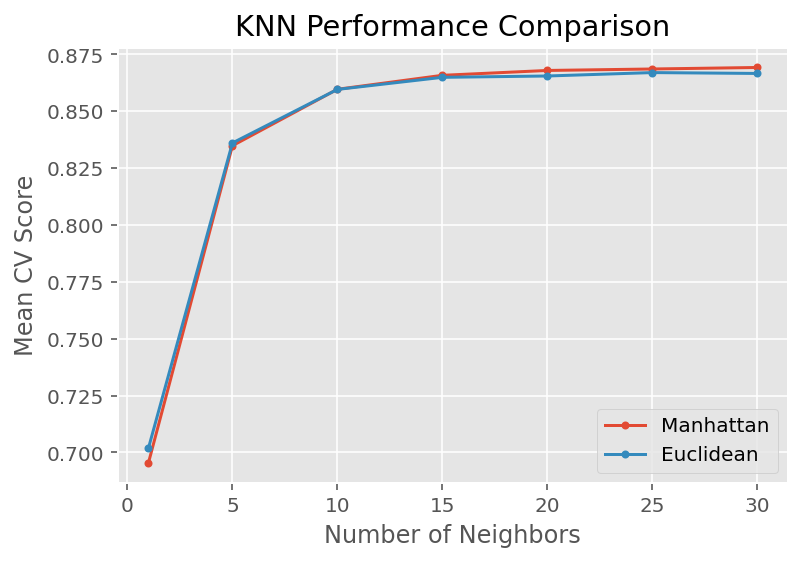

In [20]:
for i in ["Manhattan", "Euclidean"]:
    temp = results_KNN[results_KNN['metric'] == i]
    plt.plot(temp['n_neighbors'], temp['test_score'], marker = '.', label = i)
    
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel("Mean CV Score")
plt.title("KNN Performance Comparison")
plt.show()

### Exercise 3

Fit and fine-tune a DT model using the **train** data. For fine-tuning, consider max_depth values in {3, 5, 7, 10, 12} and min_samples_split values in {2, 5, 15, 20, 25}. Also visualize the tuning results.

In [21]:
from sklearn.tree import DecisionTreeClassifier

df_classifier = DecisionTreeClassifier(random_state=999)

params_DT = {'max_depth': [3, 5, 7, 10, 12],
             'min_samples_split': [2, 5, 15, 20, 25]}
            
gs_DT = GridSearchCV(estimator=df_classifier, 
                     param_grid=params_DT, 
                     cv=cv_method_train,
                     verbose=1, 
                     scoring=scoring_metric)

gs_DT.fit(D_Train_fs, t_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [22]:
gs_DT.best_params_

{'max_depth': 7, 'min_samples_split': 5}

In [23]:
gs_DT.best_score_

0.8862641529718823

In [24]:
# Let's define a new data frame to store the DT grid search results for visualization.
results_DT = pd.DataFrame(gs_DT.cv_results_['params'])
results_DT['test_score'] = gs_DT.cv_results_['mean_test_score']
results_DT.columns

Index(['max_depth', 'min_samples_split', 'test_score'], dtype='object')

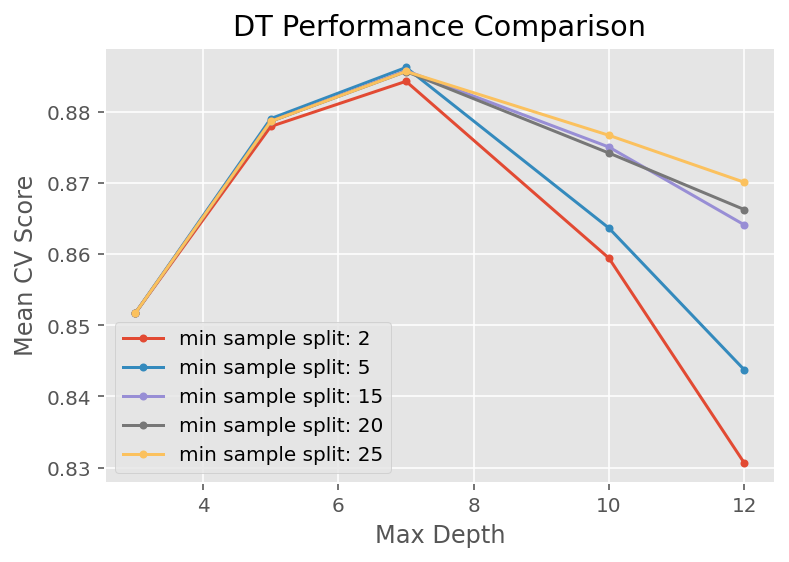

In [25]:
for i in [2, 5, 15, 20, 25]:
    temp = results_DT[results_DT['min_samples_split'] == i]
    temp_average = temp.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(temp_average, marker = '.', label = 'min sample split: ' + str(i))
    
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("DT Performance Comparison")
plt.show()

### Exercise 4

Fit and fine-tune a NB model using the **train** data. For fine-tuning, consider var_smoothing values in `np.logspace(1,-2, num=50)`. Also visualize the tuning results.

In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer

nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(1,-2, num=50)}

gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB, 
                     cv=cv_method_train,
                     verbose=1, 
                     scoring=scoring_metric)

D_Train_fs_transformed = PowerTransformer().fit_transform(D_Train_fs)

gs_NB.fit(D_Train_fs_transformed, t_train);

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [27]:
gs_NB.best_params_

{'var_smoothing': 0.3906939937054617}

In [28]:
gs_NB.best_score_

0.8866679203784997

In [29]:
# Let's define a new data frame to store the NB grid search results for visualization
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

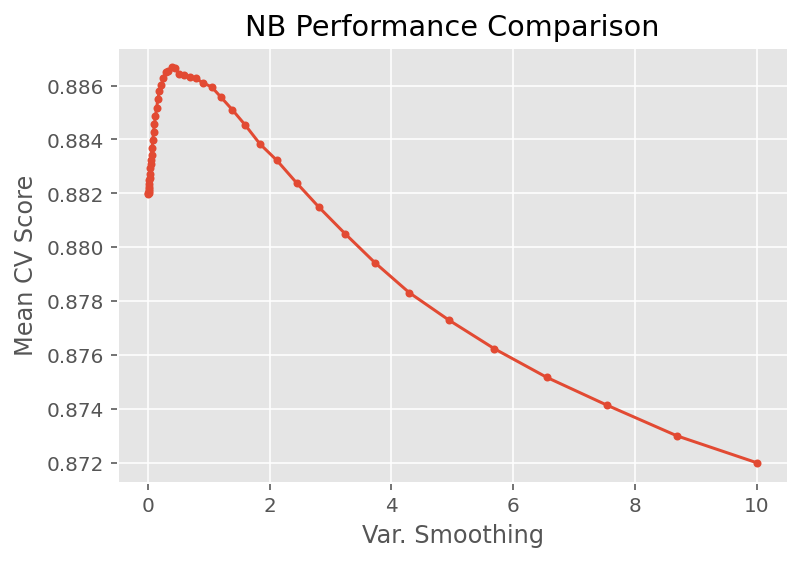

In [30]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

### Exercise 5

Fit and fine-tune a Random Forest model using the **train** data. For fine-tuning, consider n_estimators values in {100, 250, 500} and max_depth values in {3, 5, 7, 10, 12}. Also visualize the tuning results.

In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PowerTransformer

rf_classifier = RandomForestClassifier(random_state=999)

params_RF = {'n_estimators': [100, 250, 500],
             'max_depth': [5, 7, 10, 12]}

gs_RF = GridSearchCV(estimator=rf_classifier, 
                     param_grid=params_RF, 
                     cv=cv_method_train,
                     verbose=1,
                     n_jobs=-2,
                     scoring=scoring_metric)

gs_RF.fit(D_Train_fs, t_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [32]:
gs_RF.best_params_

{'max_depth': 7, 'n_estimators': 250}

In [33]:
gs_RF.best_score_

0.9068092192464776

In [34]:
# Let's define a new data frame to store the grid search results for visualization.
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']
results_RF.columns

Index(['max_depth', 'n_estimators', 'test_score'], dtype='object')

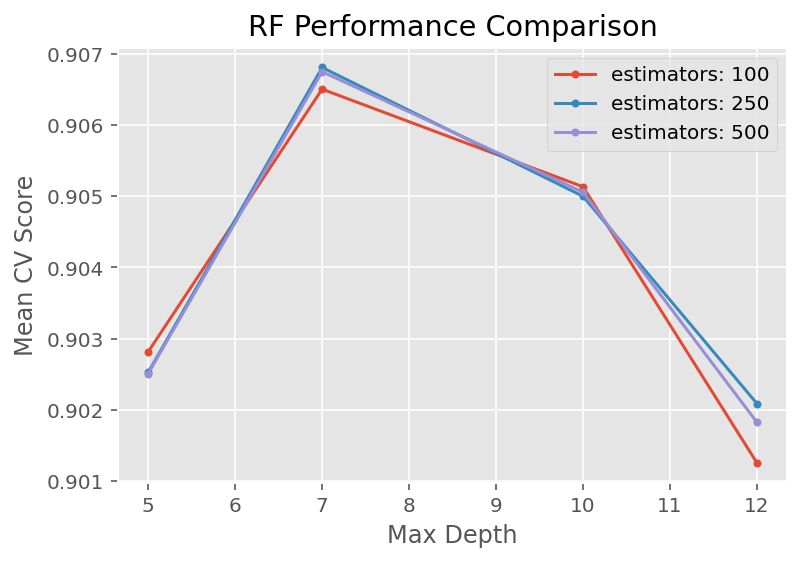

In [35]:
for i in results_RF['n_estimators'].unique():
    temp = results_RF[results_RF['n_estimators'] == i]
    plt.plot(temp['max_depth'], temp['test_score'], marker = '.', label = 'estimators: ' + str(i))
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("RF Performance Comparison")
plt.show()

### Exercise 6

What we would like to do now is to "fit" each tuned classifier (with their best set of hyperparameter values) on the **test** data in a cross-validated fashion to figure out which (tuned) classifier performs the best. This way, we will be measuring performance of the tuned classifiers on data that they did not "see" previously.

Since cross validation itself is a random process, we would like to perform pairwise t-tests to determine if any difference between the performance of any two (tuned) classifiers is statistically significant. Specifically, we first perform 5-fold stratified cross-validation (without any repetitions) on each (tuned) classifier where we use the same seed in each of the four cross-validation runs. Second, we conduct a paired t-test for the AUC score between the following (tuned) classifier combinations.

For this question, perform the procedures discussed above and decide if any one the tuned classifiers is statistically better than the rest at a 95% significance level.

In [36]:
from sklearn.model_selection import cross_val_score
cv_method_test = StratifiedKFold(n_splits=5, shuffle=True, random_state=999)

In [37]:
cv_results_KNN = cross_val_score(estimator=gs_KNN.best_estimator_,
                                 X=D_Test_fs,
                                 y=t_test, 
                                 cv=cv_method_test, 
                                 scoring='roc_auc')
cv_results_KNN.mean()

0.8698548148148149

In [38]:
cv_results_DT = cross_val_score(estimator=gs_DT.best_estimator_,
                                 X=D_Test_fs,
                                 y=t_test, 
                                 cv=cv_method_test, 
                                 scoring='roc_auc')
cv_results_DT.mean()

0.8579674074074074

In [39]:
# make sure you don't forget the power transformation

D_Test_fs_transformed = PowerTransformer().fit_transform(D_Test_fs)

cv_results_NB = cross_val_score(estimator=gs_NB.best_estimator_,
                                 X=D_Test_fs_transformed,
                                 y=t_test, 
                                 cv=cv_method_test, 
                                 scoring='roc_auc')
cv_results_NB.mean()

0.8966044444444445

In [40]:
cv_results_RF = cross_val_score(estimator=gs_RF.best_estimator_,
                                 X=D_Test_fs,
                                 y=t_test, 
                                 cv=cv_method_test, 
                                 n_jobs=-2,
                                 scoring='roc_auc')
cv_results_RF.mean()

0.9081125925925926

In [41]:
from scipy import stats

# RF seems to be the best, so let's compare that to the others
# any p-value < 0.05 indicates a statistically significant result

print(stats.ttest_rel(cv_results_RF, cv_results_KNN))
print(stats.ttest_rel(cv_results_RF, cv_results_DT))
print(stats.ttest_rel(cv_results_RF, cv_results_NB))

Ttest_relResult(statistic=7.815450855150375, pvalue=0.001446641754333493)
Ttest_relResult(statistic=4.369008643730098, pvalue=0.011977362937008334)
Ttest_relResult(statistic=1.6818508719146943, pvalue=0.16788992249462276)


### Exercise 7

Rerun your notebook with different number of features (e.g., 5, 15, 20). Also try with no feature selection at all (set num_features=41).
Comment if your results improve. Which number of features seem to work best?

### Optional: beyond two hyper-parameters

In previous exercises, we have created a decision tree and a random forest. For these models, we "tuned" up to two hyper-parameters. Sometimes two parameters are not sufficient. We need more! In this optional exercise, we will illustrate how to go beyond tuning more than two hyper parameters of a random forest. In particular, we would like to assess if the performance would improve when entropy is used instead of gini. 

In [42]:
rf_classifier = RandomForestClassifier(random_state=999)

# Obtain the parameters
rf_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 999,
 'verbose': 0,
 'warm_start': False}

In [43]:
params_RF = {'n_estimators': [100, 250, 500],
             'max_depth': np.arange(5, 12),
             'criterion': ['gini', 'entropy']}

gs_RF = GridSearchCV(estimator=rf_classifier, 
                     param_grid=params_RF, 
                     cv=cv_method_train,
                     verbose=1,
                     n_jobs=-2,
                     scoring=scoring_metric)

gs_RF.fit(D_Train_fs, t_train);

Fitting 5 folds for each of 42 candidates, totalling 210 fits


In [44]:
rf_results = pd.DataFrame.from_dict(gs_RF.cv_results_['params'])
rf_results['score'] = gs_RF.cv_results_['mean_test_score']

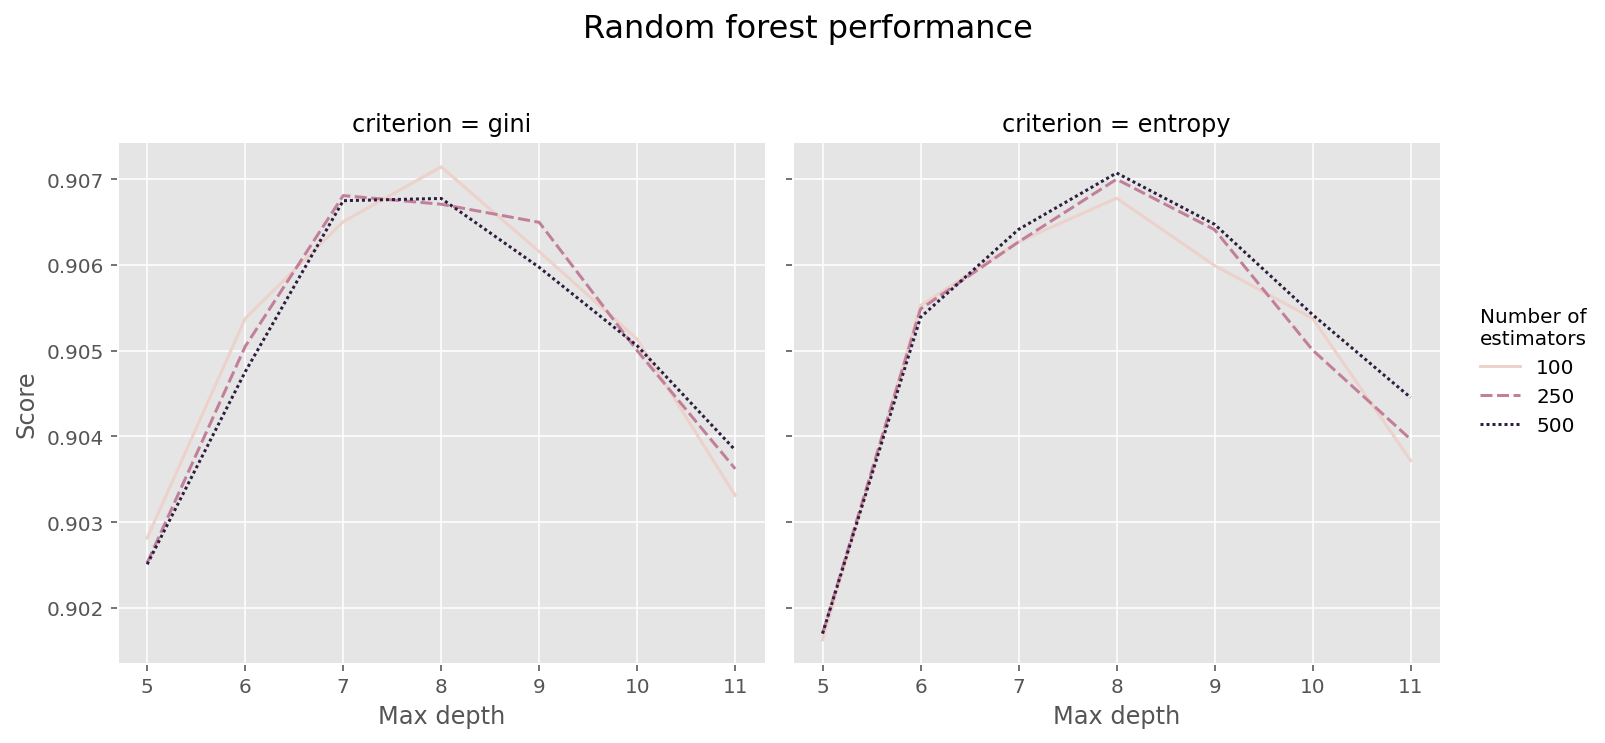

In [45]:
import seaborn as sns
rel_plot = sns.relplot(
    data=rf_results, x="max_depth", y="score",
    col="criterion", hue="n_estimators", style="n_estimators",
    kind="line"
)
rel_plot.axes[0,0].set_xlabel('Max depth')
rel_plot.axes[0,1].set_xlabel('Max depth')
rel_plot.axes[0,0].set_ylabel('Score')
rel_plot._legend.set_title("Number of\nestimators")
rel_plot._legend._legend_box.align = "left"
rel_plot.fig.subplots_adjust(top=0.8)
rel_plot.fig.suptitle('Random forest performance', fontsize=16)
plt.show(rel_plot)

### Optional: imbalanced class mitigation in hyper-parameter tuning

Sometimes, a classification problem might have "imbalanced class issue" - that is one of the target labels is a "minority class". For example, the income data has 25 % of instances earning more than USD 50,000 (positive label). There are many approaches to mitigate the imbalanced class. One is to adopt the appropriate metrics. We have been using ROC as the scoring metric as it can balance the true positive rate (TPR) and the true negative rate (TNR). Another approach is to impose "class weight" during hyper-parameter tuning.

In [46]:
np.unique(t_test, return_counts=True)

(array([0, 1], dtype=int64), array([1125,  375], dtype=int64))

In [47]:
from sklearn.metrics import classification_report
t_pred = gs_RF.predict(D_Test_fs)
print(classification_report(t_test, t_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1125
           1       0.78      0.59      0.67       375

    accuracy                           0.86      1500
   macro avg       0.83      0.77      0.79      1500
weighted avg       0.85      0.86      0.85      1500



In [48]:
rf_classifier_wgt = RandomForestClassifier(random_state=999, criterion='entropy')
params_RF_wgt = {'n_estimators': [100, 250, 500],
                 'max_depth': np.arange(5, 12),
                 'class_weight': [{0:1, 1:1}, {0:1, 1:3}, {0:1, 1:4}]}

gs_RF_wgt = GridSearchCV(estimator=rf_classifier_wgt, 
                         param_grid=params_RF_wgt, 
                         cv=cv_method_train,
                         verbose=1,
                         n_jobs=-2,
                         scoring=scoring_metric)

gs_RF_wgt.fit(D_Train_fs, t_train);

Fitting 5 folds for each of 63 candidates, totalling 315 fits


In [49]:
gs_RF_wgt.best_params_

{'class_weight': {0: 1, 1: 1}, 'max_depth': 8, 'n_estimators': 500}

In [50]:
t_pred_wgt = gs_RF_wgt.predict(D_Test_fs)
print(classification_report(t_test, t_pred_wgt))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1125
           1       0.77      0.56      0.65       375

    accuracy                           0.85      1500
   macro avg       0.82      0.75      0.78      1500
weighted avg       0.84      0.85      0.84      1500



***
www.featureranking.com